# NAIVE BAYES ALGORITHM on Amazon Fine Food Reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

## Loading,Cleaning & Preprocessing the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".*italicized text*

In [0]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

####Import all Required Libraries 

In [0]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#### Pull the dataset from Google Drive & mount

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Connect to sqlite and fetch the data using SQL Query

In [4]:
con = sqlite3.connect("/content/drive/My Drive/Colab Notebooks/database.sqlite")

filtered_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""",con);
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
filtered_data.shape

(525814, 10)

In [6]:
def partition(x):
  if x < 3 :
    return 'negative'
  return 'positive'

actualScore=filtered_data['Score']
positive_negative=actualScore.map(partition)
filtered_data['Score']=positive_negative
print("Number of datapoints",filtered_data.shape)
filtered_data.head(3)

Number of datapoints (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [8]:
print(display.shape)
display.head(3)

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2


In [9]:
display[display["UserId"]=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [10]:
display['COUNT(*)'].sum()

393063

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [12]:
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final_data.shape

(364173, 10)

In [13]:
(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

#### Count the Positive and Negative Review Counts

In [16]:
print(final_data.shape)

#How many positive and negative reviews are present in our dataset?
final_data['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#### Import nltk library

In [0]:
pip install nltk

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### Find the Stopping Words

In [18]:
stopping_words = set(stopwords.words('english'))
print(stopping_words)

{'by', "don't", 'couldn', 'we', 'themselves', 'ourselves', "wasn't", "weren't", 'for', 'because', 'wouldn', 'can', 'wasn', 'my', 'am', 'both', 'theirs', 'no', 'above', 's', 'but', 'in', 'each', "won't", 'out', "it's", 'her', 'here', 'any', "shan't", 're', 'yourself', 'ours', 'being', 'only', 'did', 'below', 'your', 'there', 'after', 'haven', 'against', "you've", 'or', 'about', 'from', 'on', 'been', 'further', 'd', 'were', 'hers', 'yourselves', 'she', 'mightn', "shouldn't", "she's", 'just', 'o', 'do', 'again', 'hasn', 'nor', "isn't", 'weren', 'a', 'itself', 'them', 'these', "haven't", "needn't", 'before', 'to', 'myself', 'hadn', "should've", 'should', 'are', 'their', 'yours', 'not', 'so', "you'll", 'where', 'isn', "you'd", 'between', 'how', 'i', 'then', 'shan', 'won', 'is', 'was', 'as', 'own', "you're", 'its', 'had', 'up', 'such', 'who', 'm', 'will', "mustn't", 'over', 'ain', 'at', 'himself', 'once', 'doing', 'the', 'you', 'more', 'down', 'll', 'same', 'most', 'why', 'have', 'of', 'when

In [0]:
def clean_html(text):
    clean_r = re.compile('<,*?>')
    clean_text = re.sub(clean_r,'',text)
    return clean_text

def Clean_punc(text):
    clean_sentence = re.sub(r'[?|!|\'|"|#]',r' ',text)
    clean_data = re.sub(r'[.|,|)|(|\|/)]',r' ',clean_sentence)
    return clean_data

In [20]:
from tqdm import tqdm
import os
import pdb
import pickle

from tqdm import tqdm
import os
import pdb
import pickle

stem_no = nltk.stem.SnowballStemmer('english')

if not os.path.isfile('final_data.sqlite'):
    final_string=[]
    all_positive_words=[]
    all_negative_words=[]
    for i,sentence in enumerate(tqdm(final_data['Text'].values)):
        filtered_sentence=[]
        sent_without_html_tags=clean_html(sentence)
        #pdb.set_trace()
        for w in sent_without_html_tags.split():
            for cleaned_words in Clean_punc(w).split():
                if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                    if(cleaned_words.lower() not in stopping_words) :
                        stemming=(stem_no.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(stemming)
                        if(final_data['Score'].values)[i]=='positive':
                            all_positive_words.append(stemming)
                        if(final_data['Score'].values)[i]=='negative':
                            all_negative_words.append(stemming)
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
        
    final_data['Cleaned_text']=final_string
    final_data['Cleaned_text']=final_data['Cleaned_text'].str.decode("utf-8")    
    
    conn = sqlite3.connect('final_data.sqlite')
    cursor=conn.cursor
    conn.text_factory = str
    final_data.to_sql('Reviews',conn,schema=None,if_exists='replace',index=True,index_label=None,chunksize=None,dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl','wb') as f :
        pickle.dump(all_positive_words,f)
    with open('negative_words.pkl','wb') as f :
        pickle.dump(all_negative_words,f)

100%|██████████| 364171/364171 [06:34<00:00, 922.52it/s]


#### Find the Total Number of Words in the Review Text

In [0]:
final_data['total_words'] = [len(x.split()) for x in final_data['Cleaned_text'].tolist()] 

In [22]:
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text,total_words
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,34
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...,27
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...,15


#### Sort the data based on the Time

In [0]:
final_data.sort_values(by=['Time'], inplace=True, ascending=True)

In [24]:
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text,total_words
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,34
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,30
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,13


In [25]:
final_data.shape

(364171, 12)

In [26]:
final_data_100K=final_data[0:100000]
amazon_polarity_labels=final_data_100K['Score'].values
final_data_100K.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text,total_words
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,34
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,30


## Split the Dataset into Train , Test & Cross Validation

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_1,X_Test,Y_1,Y_Test = train_test_split(final_data_100K,amazon_polarity_labels,test_size=0.2,random_state=0)
X_Train,X_CV,Y_Train,Y_CV = train_test_split(X_1,Y_1,test_size=0.2)

In [0]:
X_Train.to_csv('amazonfine_food_train_data.csv') 

In [29]:
X_Train.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text,total_words
7184,7852,B000ELWDRI,A17LYITJK2TZ6K,D. Day,1,1,negative,1253318400,"Product is fine, but the price is more than at...",I can get this at my local grocery store for $...,get local groceri store per,5
443174,479202,B0007SNZBQ,A1S5Z3IXRBNOLE,Patrick M. Sutton,0,0,positive,1201392000,The best cereal you won't find on your grocer'...,I absolutely love this cereal. It's really for...,absolut love cereal realli adult sweet right b...,21
305894,331272,B001P74NXM,AFHODA11ACXVX,"M. Chrisman ""countrysprout""",0,0,positive,1243296000,OG Raw Blue Agave ROCKS!,I would not hesitate to recommend this product...,would hesit recommend product particular look ...,115


## Bag Of Words(BoW) Vectorization Technique on Naive Bayes Algorithm

In [30]:
print(X_Train.shape, Y_Train.shape)
print(X_CV.shape, Y_CV.shape)
print(X_Test.shape, Y_Test.shape)

print("="*100)


count_vector=CountVectorizer(min_df=1)
X_Train_data_bow=(count_vector.fit_transform(X_Train['Cleaned_text'].values))
X_Test_data_bow=(count_vector.transform(X_Test['Cleaned_text'].values))
X_CV_data_bow=(count_vector.transform(X_CV['Cleaned_text'].values))

print("After vectorizations")
print(X_Train_data_bow.shape, Y_Train.shape)
print(X_CV_data_bow.shape, Y_CV.shape)
print(X_Test_data_bow.shape, Y_Test.shape)
print("="*100)

(64000, 12) (64000,)
(16000, 12) (16000,)
(20000, 12) (20000,)
After vectorizations
(64000, 29389) (64000,)
(16000, 29389) (16000,)
(20000, 29389) (20000,)


### Use MultiNomial Naive Bayes and GridSearchCV using 10 Fold Cross Validation to find Best Alpha

In [0]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

def NaiveBayes_Optimal_Alpha(x_training_data,y_training_data):
  grid_params = { 'alpha' : [10**x for x in range(-5,3)]              
                 }
  naive_bayes = MultinomialNB(class_prior=[0.5,0.5],fit_prior=True)
  clf=GridSearchCV(naive_bayes,grid_params,scoring='roc_auc',return_train_score=True,cv=10)
  clf.fit(x_training_data,y_training_data)
  results = pd.DataFrame.from_dict(clf.cv_results_)
  results = results.sort_values(['param_alpha'])
  train_auc= results['mean_train_score']
  train_auc_std= results['std_train_score']
  cv_auc = results['mean_test_score'] 
  cv_auc_std= results['std_test_score']
  alpha =  results['param_alpha']
  #print(type(alpha))
  #print(alpha)
  log_alpha=np.log10(list(results["param_alpha"]))
  print(clf.best_score_)
  print(clf.best_params_)
  plt.plot(log_alpha, train_auc, label='Train AUC')
  plt.plot(log_alpha, cv_auc, label='CV AUC')
  plt.scatter(log_alpha, train_auc, label='Train AUC points')
  plt.scatter(log_alpha, cv_auc, label='CV AUC points')
  plt.legend()
  plt.xlabel("Log of alpha: hyperparameter")
  plt.ylabel("AUC")
  plt.title("Hyper parameter Vs AUC plot")
  plt.grid()
  plt.show()
  return results,clf,naive_bayes

0.8967704367691779
{'alpha': 0.1}


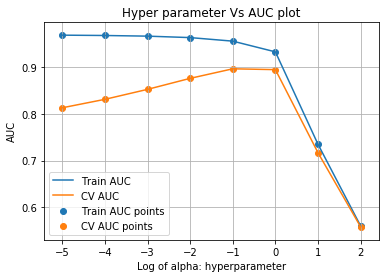

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.194286,0.005829,0.018244,0.000482,1e-05,{'alpha': 1e-05},0.832927,0.815639,0.815289,0.814726,0.813180,0.810585,0.800167,0.807801,0.822658,0.799283,0.813225,0.009438,6,0.968593,0.968835,0.969060,0.969436,0.968304,0.968817,0.968905,0.969078,0.969140,0.968859,0.968903,0.000294
1,0.192298,0.001132,0.018999,0.002144,0.0001,{'alpha': 0.0001},0.849612,0.833737,0.832425,0.831621,0.830459,0.828898,0.818649,0.825476,0.840005,0.822257,0.831314,0.008370,5,0.967876,0.968108,0.968341,0.968731,0.967561,0.968099,0.968198,0.968302,0.968415,0.968107,0.968174,0.000299
2,0.191991,0.007065,0.017936,0.000361,0.001,{'alpha': 0.001},0.868611,0.853764,0.852920,0.850806,0.851579,0.850166,0.844108,0.845603,0.862053,0.847447,0.852706,0.007105,4,0.966498,0.966710,0.966939,0.967384,0.966151,0.966712,0.966830,0.966856,0.967034,0.966636,0.966775,0.000311
3,0.191347,0.001288,0.018263,0.000175,0.01,{'alpha': 0.01},0.888155,0.876968,0.875863,0.873261,0.874875,0.875264,0.870697,0.867738,0.885280,0.874947,0.876305,0.005837,3,0.963424,0.963637,0.963873,0.964358,0.963015,0.963566,0.963639,0.963691,0.963999,0.963421,0.963662,0.000345
4,0.191457,0.003335,0.018273,0.000531,0.1,{'alpha': 0.1},0.907117,0.899100,0.894295,0.891649,0.893452,0.893583,0.896534,0.890760,0.901664,0.899549,0.896770,0.004836,1,0.955864,0.955947,0.956356,0.956936,0.955313,0.955824,0.955925,0.956045,0.956555,0.955782,0.956055,0.000431


In [32]:
results,best_Alpha,nb_MultiNomial =NaiveBayes_Optimal_Alpha(X_Train_data_bow,Y_Train)
results.head()

In [33]:
print(best_Alpha.best_score_)
print(best_Alpha.best_params_)
type(best_Alpha.best_params_)

0.8967704367691779
{'alpha': 0.1}


dict

### BEST ALPHA = 0.1 For Bag Of Words Featurization technique & BEST Score is 0.89886

In [34]:
best_alpha = best_Alpha.best_params_
best_alpha=best_alpha.get("alpha")
print(best_alpha)

0.1


#### Convert Score to 1 & 0 for Trainig and Test

In [0]:
Y_Train_Binary = np.where(Y_Train == 'positive',1,0)

In [0]:
Y_Test_Binary = np.where(Y_Test == 'positive',1,0)

#### PLOT THE TRAIN AUC AND TEST AUC FOR BEST ALPHA

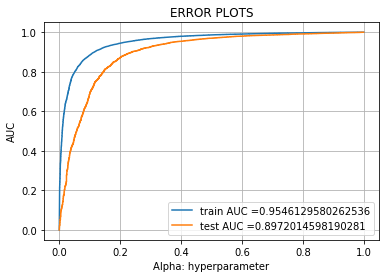

In [39]:
from sklearn.metrics import roc_curve, auc
naive_bayes = MultinomialNB(alpha=best_alpha,fit_prior=True,class_prior=[0.5,0.5])
naive_bayes.fit(X_Train_data_bow,Y_Train)
pred_test_data=naive_bayes.predict(X_Test_data_bow)
y_train_predicted_prob = naive_bayes.predict_proba(X_Train_data_bow)[:,1]
y_test_predicted_prob=naive_bayes.predict_proba(X_Test_data_bow)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### find the Top 20 Positive and Negataive Features for BoW algorithm

In [0]:
def findMax_features(naive_bayes):
  max_ind_neg=np.argsort((naive_bayes.feature_log_prob_)[0])[::-1][0:10]
  max_ind_pos=np.argsort((naive_bayes.feature_log_prob_)[1])[::-1][0:10]
  return max_ind_neg,max_ind_pos

In [41]:
imp_neg_features ,imp_pos_features = findMax_features(naive_bayes)
print("---------------------------------------------------------")
print(imp_pos_features) 
print("---------------------------------------------------------")
print(imp_neg_features)

---------------------------------------------------------
[14792 25550 10835  9514 11093 25626 15121 27548 20272 18056]
---------------------------------------------------------
[25550 14792 20272 18056  9514 26581 28923 10835 27548 25626]


In [42]:
feature_names = count_vector.get_feature_names()
print(feature_names)
coefs_with_fns = sorted(zip(naive_bayes.coef_[0], feature_names))
top_features = zip(coefs_with_fns[:20], coefs_with_fns[:-(20 + 1):-1])
list(top_features)

['aaa', 'aaaaaaaaagghh', 'aaaaah', 'aaaaahhhhhhhhhhhhhhhh', 'aaaah', 'aaah', 'aacur', 'aadp', 'aaf', 'aafco', 'aah', 'aahh', 'aalmost', 'aand', 'aardvark', 'ab', 'aback', 'abandon', 'abaolut', 'abattoir', 'abba', 'abbey', 'abbi', 'abbott', 'abbrevi', 'abc', 'abcstor', 'abd', 'abdomen', 'abdomin', 'aber', 'aberdeen', 'abhor', 'abhorr', 'abi', 'abid', 'abigirl', 'abil', 'abit', 'abita', 'abj', 'abl', 'abnorm', 'aboard', 'abomin', 'abondanza', 'aboout', 'aboslut', 'abosolut', 'abot', 'aboth', 'abound', 'abour', 'abouy', 'abouyt', 'abovement', 'aboveour', 'abpv', 'abras', 'abreva', 'abrevi', 'abroad', 'abrupt', 'abruzzo', 'abscess', 'abscond', 'absenc', 'absens', 'absensc', 'absent', 'absolu', 'absolulti', 'absolut', 'absolutali', 'absoluteki', 'absolutelli', 'absolutelti', 'absolutey', 'absolutley', 'absolutuley', 'absolv', 'absorb', 'absorbt', 'absorpt', 'absoult', 'absoulut', 'absout', 'abstain', 'abstin', 'abstract', 'absulut', 'absurd', 'abt', 'abu', 'abud', 'abuela', 'abuelita', 'abu

[((-16.79910946908463, 'abhorr'), (-4.432701025354602, 'like')),
 ((-16.79910946908463, 'abosolut'), (-4.480016221414484, 'tast')),
 ((-16.79910946908463, 'abrevi'), (-4.606775772165058, 'good')),
 ((-16.79910946908463, 'accepet'), (-4.63385360975494, 'flavor')),
 ((-16.79910946908463, 'accor'), (-4.656930219496708, 'great')),
 ((-16.79910946908463, 'accordng'), (-4.659812511952273, 'tea')),
 ((-16.79910946908463, 'accourd'), (-4.691857658503583, 'love')),
 ((-16.79910946908463, 'accpet'), (-4.714408164484647, 'use')),
 ((-16.79910946908463, 'acesuflamek'), (-4.732925523963074, 'product')),
 ((-16.79910946908463, 'acknowled'), (-4.785220855061041, 'one')),
 ((-16.79910946908463, 'acronym'), (-4.89285220782951, 'tri')),
 ((-16.79910946908463, 'actal'), (-4.975315330587295, 'make')),
 ((-16.79910946908463, 'activateand'), (-5.107109379571092, 'get')),
 ((-16.79910946908463, 'activist'), (-5.182085284186089, 'coffe')),
 ((-16.79910946908463, 'actulli'), (-5.252352788245558, 'amazon')),
 (

#### Find ROC AUC Score

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_Test,y_test_predicted_prob)

0.8972014598190281

#### Calculate Precision , Recall , F1-Score and Conufusion Matrix

In [44]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(Y_Test,pred_test_data))
print(confusion_matrix(Y_Test,pred_test_data))

              precision    recall  f1-score   support

    negative       0.50      0.77      0.61      2457
    positive       0.97      0.89      0.93     17543

    accuracy                           0.88     20000
   macro avg       0.73      0.83      0.77     20000
weighted avg       0.91      0.88      0.89     20000

[[ 1897   560]
 [ 1869 15674]]


By Looking at the Confusion Matrix , it looks like there is an increase True Positive(TP) and True Negative(TN) values. We should be good here

## Tf-IDF Vectorization Technique on Naive Bayes Algorithm

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

print(X_Train.shape, Y_Train.shape)
print(X_CV.shape, Y_CV.shape)
print(X_Test.shape, Y_Test.shape)

print("="*100)


tfidf_vector=TfidfVectorizer(min_df=10)
X_Train_data_tfidf=(tfidf_vector.fit_transform(X_Train['Cleaned_text'].values))
X_Test_data_tfidf=(tfidf_vector.transform(X_Test['Cleaned_text'].values))
X_CV_data_tfidf=(tfidf_vector.transform(X_CV['Cleaned_text'].values))

print("After vectorizations")
print(X_Train_data_tfidf.shape, Y_Train.shape)
print(X_CV_data_tfidf.shape, Y_CV.shape)
print(X_Test_data_tfidf.shape, Y_Test.shape)
print("="*100)

(64000, 12) (64000,)
(16000, 12) (16000,)
(20000, 12) (20000,)
After vectorizations
(64000, 6773) (64000,)
(16000, 6773) (16000,)
(20000, 6773) (20000,)


#### Use Multinomial Naive Bayes and GridSearchCV using 10 Fold Cross Validation to find Best Alpha

0.9161005045766709
{'alpha': 0.1}


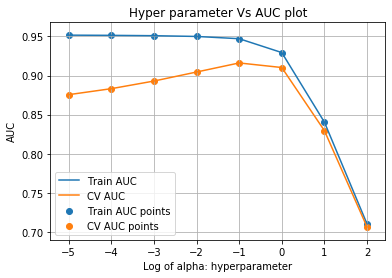

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.198574,0.001745,0.017434,0.000329,1e-05,{'alpha': 1e-05},0.877475,0.881453,0.878077,0.871077,0.881012,0.868775,0.870986,0.869336,0.883743,0.873500,0.875543,0.005210,6,0.951738,0.951338,0.951628,0.952519,0.951173,0.951458,0.951534,0.952049,0.951694,0.951338,0.951647,0.000374
1,0.198097,0.001037,0.017978,0.002481,0.0001,{'alpha': 0.0001},0.884965,0.889221,0.885457,0.881091,0.886632,0.877158,0.878290,0.877469,0.890028,0.881725,0.883204,0.004505,5,0.951506,0.951111,0.951382,0.952278,0.950910,0.951198,0.951292,0.951792,0.951444,0.951095,0.951401,0.000375
2,0.195315,0.003145,0.016920,0.000346,0.001,{'alpha': 0.001},0.894675,0.899117,0.895094,0.892651,0.893411,0.888607,0.887918,0.888000,0.898075,0.892024,0.892957,0.003765,4,0.951075,0.950682,0.950926,0.951844,0.950432,0.950725,0.950850,0.951331,0.950988,0.950642,0.950949,0.000382
3,0.198044,0.002141,0.017351,0.000324,0.01,{'alpha': 0.01},0.906410,0.910232,0.906178,0.903898,0.903245,0.901344,0.899754,0.901012,0.907617,0.905315,0.904500,0.003103,3,0.950154,0.949759,0.949953,0.950923,0.949440,0.949746,0.949919,0.950360,0.950029,0.949679,0.949996,0.000394
4,0.197279,0.003055,0.017182,0.000410,0.1,{'alpha': 0.1},0.916494,0.921193,0.916906,0.914911,0.915194,0.911861,0.913360,0.914512,0.917449,0.919126,0.916101,0.002607,1,0.947345,0.946889,0.947037,0.948034,0.946534,0.946854,0.947044,0.947392,0.947162,0.946805,0.947109,0.000392


In [46]:
results,best_Alpha,nb_MultiNomial =NaiveBayes_Optimal_Alpha(X_Train_data_tfidf,Y_Train)
results.head()

#### BEST ALPHA = 0.1 FOR TF-ID FEATURIZATION TECHNIQUE & BEST SCORE IS 0.91...

In [47]:
best_alpha = best_Alpha.best_params_
best_alpha=best_alpha.get("alpha")
print(best_alpha)

0.1


#### PLOT THE TRAIN AUC AND TEST AUC FOR BEST ALPHA

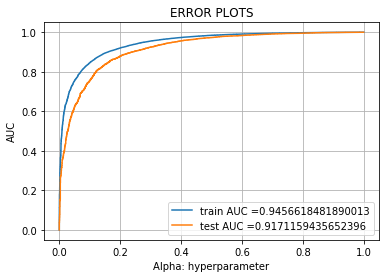

In [48]:
naive_bayes = MultinomialNB(alpha=best_alpha,fit_prior=True,class_prior=[0.5,0.5])
naive_bayes.fit(X_Train_data_tfidf,Y_Train)
pred_test_data=naive_bayes.predict(X_Test_data_tfidf)
y_train_predicted_prob = naive_bayes.predict_proba(X_Train_data_tfidf)[:,1]
y_test_predicted_prob=naive_bayes.predict_proba(X_Test_data_tfidf)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### Find the Top 20 Posiive and Negative Features for BoW algorithm

In [49]:
imp_neg_features ,imp_pos_features = findMax_features(naive_bayes)
print("---------------------------------------------------------")
print(imp_pos_features) 
print("---------------------------------------------------------")
print(imp_neg_features)

---------------------------------------------------------
[2637 5946 3512 2578 5931 3433 2277 4628 6367 1178]
---------------------------------------------------------
[5931 4628 3433 6680 2277 4123 6190  810 4150 1178]


In [50]:
feature_names = tfidf_vector.get_feature_names()
print(feature_names)
coefs_with_fns = sorted(zip(naive_bayes.coef_[0], feature_names))
top_features = zip(coefs_with_fns[:20], coefs_with_fns[:-(20 + 1):-1])
list(top_features)

['abandon', 'abc', 'abdomin', 'abil', 'abl', 'abroad', 'absenc', 'absent', 'absolut', 'absorb', 'absorpt', 'absurd', 'abund', 'abus', 'acacia', 'academi', 'acai', 'accent', 'accept', 'access', 'accessori', 'accid', 'accident', 'accommod', 'accompani', 'accomplish', 'accord', 'account', 'accumul', 'accur', 'accus', 'accustom', 'acerola', 'ach', 'achiev', 'acid', 'acknowledg', 'acn', 'acquaint', 'acquir', 'acr', 'acrid', 'across', 'act', 'action', 'activ', 'actor', 'actual', 'ad', 'adagio', 'adam', 'adapt', 'add', 'addict', 'addit', 'address', 'adequ', 'adhd', 'adher', 'adhes', 'adjust', 'administ', 'administr', 'admir', 'admit', 'adobo', 'adopt', 'ador', 'adult', 'adulter', 'advanc', 'advantag', 'adventur', 'advers', 'advert', 'advertis', 'advic', 'advis', 'advoc', 'aerat', 'aero', 'aerogarden', 'aerogrow', 'aesthet', 'affair', 'affect', 'affili', 'afford', 'afghanistan', 'aficionado', 'aforement', 'afraid', 'africa', 'african', 'afteral', 'afterlif', 'afternoon', 'aftertast', 'afterwar

[((-13.371141609478268, 'worthless'), (-4.97208572293706, 'great')),
 ((-13.319947357716995, 'insuffici'), (-4.994069271981616, 'tea')),
 ((-13.077229244518215, 'disclos'), (-5.023510661083602, 'love')),
 ((-13.072272467472127, 'unpalat'), (-5.05176923791341, 'good')),
 ((-13.070146590509903, 'administr'), (-5.062031051988383, 'tast')),
 ((-13.039911759582079, 'pawn'), (-5.084365243798258, 'like')),
 ((-12.976498594133405, 'fragment'), (-5.15570896123825, 'flavor')),
 ((-12.808912194408723, 'selenit'), (-5.174808612687513, 'product')),
 ((-12.808842002701113, 'endocrin'), (-5.260361778321145, 'use')),
 ((-12.79385781478159, 'hydropon'), (-5.315994275297357, 'coffe')),
 ((-12.792752956372002, 'brownish'), (-5.352429029615312, 'one')),
 ((-12.732115795508921, 'glossari'), (-5.404556640617229, 'tri')),
 ((-12.728875251701597, 'perpetu'), (-5.459142741354804, 'make')),
 ((-12.68657635128489, 'baselin'), (-5.507247847724007, 'best')),
 ((-12.611976832407393, 'blech'), (-5.558753946456716, '

#### Find ROC AUC SCORE

In [51]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_Test,y_test_predicted_prob)

0.9171159435652396

#### Calculate Precision , Recall , F1 Score and Confusion Matrix

In [52]:
print(classification_report(Y_Test,pred_test_data))
print(confusion_matrix(Y_Test,pred_test_data))

              precision    recall  f1-score   support

    negative       0.46      0.81      0.59      2457
    positive       0.97      0.87      0.92     17543

    accuracy                           0.86     20000
   macro avg       0.72      0.84      0.75     20000
weighted avg       0.91      0.86      0.88     20000

[[ 1993   464]
 [ 2305 15238]]


By looking at the Confusion Matrix , looks like there is an increase in False Negative(FN) value which is not good. There is an increase in True Positive(TP)

##  Bag Of Words Vectorization Technique on Naive Bayes Algorithm 
### Added New Column in the data set called "TotalWords". This will find the total words available in the Words.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_1,X_Test,Y_1,Y_Test = train_test_split(final_data_100K,amazon_polarity_labels,test_size=0.2,random_state=0)
X_Train,X_CV,Y_Train,Y_CV = train_test_split(X_1,Y_1,test_size=0.2)

#### Encode the Numerical Feature

In [54]:
from sklearn.preprocessing import Normalizer

print(X_Train.shape, Y_Train.shape)
print(X_CV.shape, Y_CV.shape)
print(X_Test.shape, Y_Test.shape)

print("="*100)

normalizer=Normalizer()
X_Train_totalwords=normalizer.fit_transform(X_Train['total_words'].values.reshape(1,-1))

X_Test_totalwords=normalizer.transform(X_Test['total_words'].values.reshape(1,-1))
X_CV_totalwords=normalizer.transform(X_CV['total_words'].values.reshape(1,-1))

print("After vectorizations")
print(X_Train_totalwords.shape, Y_Train.shape)
print(X_CV_totalwords.shape, Y_CV.shape)
print(X_Test_totalwords.shape, Y_Test.shape)
print("="*100)

(64000, 12) (64000,)
(16000, 12) (16000,)
(20000, 12) (20000,)
After vectorizations
(1, 64000) (64000,)
(1, 16000) (16000,)
(1, 20000) (20000,)


In [55]:
print(X_Train.shape, Y_Train.shape)
print(X_CV.shape, Y_CV.shape)
print(X_Test.shape, Y_Test.shape)

print("="*100)


count_vector=CountVectorizer(min_df=1)
X_Train_data_bow=(count_vector.fit_transform(X_Train['Cleaned_text'].values))
X_Test_data_bow=(count_vector.transform(X_Test['Cleaned_text'].values))
X_CV_data_bow=(count_vector.transform(X_CV['Cleaned_text'].values))

print("After vectorizations")
print(X_Train_data_bow.shape, Y_Train.shape)
print(X_CV_data_bow.shape, Y_CV.shape)
print(X_Test_data_bow.shape, Y_Test.shape)
print("="*100)

(64000, 12) (64000,)
(16000, 12) (16000,)
(20000, 12) (20000,)
After vectorizations
(64000, 29389) (64000,)
(16000, 29389) (16000,)
(20000, 29389) (20000,)


#### Merge the Sparse matrix. I have transponse the Train , TEST and CV matrix for Total Words

In [56]:
from scipy.sparse import hstack
X_train_final = hstack((X_Train_data_bow,X_Train_totalwords.T)).tocsr()
X_test_final = hstack((X_Test_data_bow,X_Test_totalwords.T)).tocsr()
X_cv_final = hstack((X_CV_data_bow,X_CV_totalwords.T)).tocsr()

print("Final Data matrix")
print(X_train_final.shape, Y_Train.shape)
print(X_test_final.shape, Y_Test.shape)
print(X_cv_final.shape, Y_CV.shape)
print("="*100)

Final Data matrix
(64000, 29390) (64000,)
(20000, 29390) (20000,)
(16000, 29390) (16000,)


#### Use Multinomial Naive Bayes and GridSearchCV using 10 Fold Cross Validation to find the best Alpha

0.8953798678293321
{'alpha': 0.1}


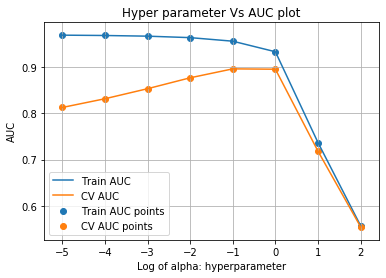

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.191642,0.004905,0.017511,0.000355,1e-05,{'alpha': 1e-05},0.795168,0.817841,0.819915,0.824053,0.816785,0.810356,0.806645,0.824225,0.806156,0.800529,0.812167,0.009458,6,0.967599,0.968191,0.967931,0.968494,0.967848,0.968171,0.968258,0.967387,0.968337,0.968052,0.968027,0.000324
1,0.186945,0.001645,0.017218,0.000310,0.0001,{'alpha': 0.0001},0.813370,0.837415,0.841563,0.842225,0.833818,0.828699,0.825203,0.839995,0.825535,0.821942,0.830977,0.009106,5,0.966873,0.967429,0.967264,0.967746,0.967092,0.967458,0.967541,0.966621,0.967626,0.967292,0.967294,0.000331
2,0.189703,0.004430,0.017284,0.000388,0.001,{'alpha': 0.001},0.835645,0.858644,0.864110,0.863004,0.853832,0.848526,0.847938,0.858638,0.848257,0.847596,0.852619,0.008276,4,0.965410,0.965942,0.965870,0.966296,0.965583,0.966015,0.966114,0.965140,0.966252,0.965807,0.965843,0.000352
3,0.190337,0.001723,0.017864,0.000465,0.01,{'alpha': 0.01},0.861559,0.880565,0.887366,0.885156,0.879280,0.870925,0.871676,0.878583,0.871083,0.875144,0.876134,0.007273,3,0.962252,0.962817,0.962718,0.963164,0.962330,0.962846,0.962987,0.961951,0.963135,0.962632,0.962683,0.000377
4,0.188594,0.001909,0.017638,0.000517,0.1,{'alpha': 0.1},0.887746,0.899178,0.904018,0.898849,0.898939,0.890225,0.888600,0.896315,0.893835,0.896093,0.895380,0.004983,1,0.954503,0.955267,0.955017,0.955557,0.954435,0.955220,0.955381,0.954281,0.955522,0.954898,0.955008,0.000440


In [57]:
results,best_Alpha,nb_MultiNomial =NaiveBayes_Optimal_Alpha(X_train_final,Y_Train)
results.head()

BEST ALPHA = 0.1 FOR BOW FEATURIZATION TECHNIQUE & BEST SCORE IS 0.8956...

In [58]:
best_alpha = best_Alpha.best_params_
best_alpha=best_alpha.get("alpha")
print(best_alpha)

0.1


#### PLOT THE TRAIN AUC AND TEST AUC FOR BEST ALPHA

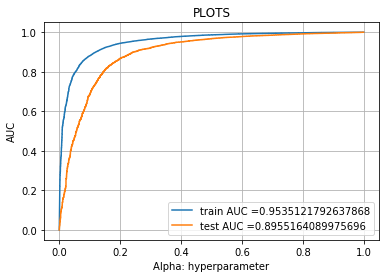

In [59]:
from sklearn.metrics import roc_curve, auc
naive_bayes = MultinomialNB(alpha=best_alpha,fit_prior=True,class_prior=[0.5,0.5])
naive_bayes.fit(X_train_final,Y_Train)
pred_test_data=naive_bayes.predict(X_test_final)
y_train_predicted_prob = naive_bayes.predict_proba(X_train_final)[:,1]
y_test_predicted_prob=naive_bayes.predict_proba(X_test_final)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("PLOTS")
plt.grid()
plt.show()

#### Find the Top 20 Positive and Negative Features for BOW Algorithm

In [60]:
imp_neg_features ,imp_pos_features = findMax_features(naive_bayes)
print("---------------------------------------------------------")
print(imp_pos_features) 
print("---------------------------------------------------------")
print(imp_neg_features)

---------------------------------------------------------
[14726 25499 10819  9453 25575 11079 15060 27520 20221 17984]
---------------------------------------------------------
[25499 14726 20221 17984  9453 26537 28911 10819 27520 25575]


In [61]:
feature_names = count_vector.get_feature_names()
coefs_with_fns = sorted(zip(naive_bayes.coef_[0], feature_names))
top_features = zip(coefs_with_fns[:20], coefs_with_fns[:-(20 + 1):-1])
list(top_features)

[((-16.79770005183023, 'aachen'), (-4.430057176675728, 'like')),
 ((-16.79770005183023, 'abhorr'), (-4.478517494922324, 'tast')),
 ((-16.79770005183023, 'ablaz'), (-4.611518937548073, 'good')),
 ((-16.79770005183023, 'abosolut'), (-4.627663994165005, 'flavor')),
 ((-16.79770005183023, 'abrevi'), (-4.638608956997299, 'tea')),
 ((-16.79770005183023, 'abvious'), (-4.656160594118514, 'great')),
 ((-16.79770005183023, 'accepet'), (-4.688298011062921, 'love')),
 ((-16.79770005183023, 'acceptalbl'), (-4.716674889276268, 'use')),
 ((-16.79770005183023, 'accor'), (-4.739831634699799, 'product')),
 ((-16.79770005183023, 'accordng'), (-4.787028123633787, 'one')),
 ((-16.79770005183023, 'accourd'), (-4.8900267035930405, 'tri')),
 ((-16.79770005183023, 'accpet'), (-4.980154279687969, 'make')),
 ((-16.79770005183023, 'acesufam'), (-5.109721044880834, 'get')),
 ((-16.79770005183023, 'ack'), (-5.148924634174383, 'coffe')),
 ((-16.79770005183023, 'acknowled'), (-5.252394525397085, 'amazon')),
 ((-16.79

#### Find ROC AUC Score

In [62]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_Test,y_test_predicted_prob)

0.8955164089975696

Calculate Precision , Recall , F1 Score and Confusion Matrix

In [63]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(Y_Test,pred_test_data))
print(confusion_matrix(Y_Test,pred_test_data))

              precision    recall  f1-score   support

    negative       0.49      0.77      0.60      2457
    positive       0.96      0.89      0.93     17543

    accuracy                           0.88     20000
   macro avg       0.73      0.83      0.76     20000
weighted avg       0.91      0.88      0.89     20000

[[ 1887   570]
 [ 1929 15614]]


## Tf-Idf Vectorization Technique for Naive Bayes Algorithm

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

print(X_Train.shape, Y_Train.shape)
print(X_CV.shape, Y_CV.shape)
print(X_Test.shape, Y_Test.shape)

print("="*100)


tfidf_vector=TfidfVectorizer(min_df=10)
X_Train_data_tfidf_final=(tfidf_vector.fit_transform(X_Train['Cleaned_text'].values))
X_Test_data_tfidf_final=(tfidf_vector.transform(X_Test['Cleaned_text'].values))
X_CV_data_tfidf_final=(tfidf_vector.transform(X_CV['Cleaned_text'].values))

print("After vectorizations")
print(X_Train_data_tfidf_final.shape, Y_Train.shape)
print(X_CV_data_tfidf_final.shape, Y_CV.shape)
print(X_Test_data_tfidf_final.shape, Y_Test.shape)
print("="*100)

(64000, 12) (64000,)
(16000, 12) (16000,)
(20000, 12) (20000,)
After vectorizations
(64000, 6753) (64000,)
(16000, 6753) (16000,)
(20000, 6753) (20000,)


In [65]:
X_train_final_tfidf = hstack((X_Train_data_tfidf_final,X_Train_totalwords.T)).tocsr()
X_test_final_tfidf = hstack((X_Test_data_tfidf_final,X_Test_totalwords.T)).tocsr()
X_cv_final_tfidf = hstack((X_CV_data_tfidf_final,X_CV_totalwords.T)).tocsr()

print("Final Data matrix")
print(X_train_final_tfidf.shape, Y_Train.shape)
print(X_test_final_tfidf.shape, Y_Test.shape)
print(X_cv_final_tfidf.shape, Y_CV.shape)
print("="*100)

Final Data matrix
(64000, 6754) (64000,)
(20000, 6754) (20000,)
(16000, 6754) (16000,)


0.914937867102587
{'alpha': 0.1}


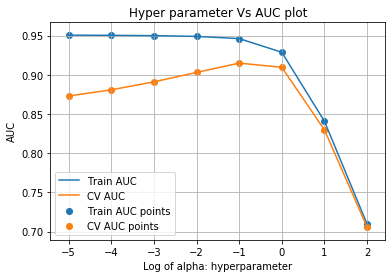

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.204991,0.021245,0.018405,0.001431,1e-05,{'alpha': 1e-05},0.860449,0.877482,0.885906,0.884512,0.876912,0.866752,0.868917,0.883419,0.858760,0.867180,0.873029,0.009449,6,0.950903,0.950452,0.950266,0.950621,0.950736,0.950717,0.951010,0.950055,0.951284,0.950124,0.950617,0.000376
1,0.188596,0.003640,0.017166,0.000243,0.0001,{'alpha': 0.0001},0.868050,0.883800,0.893638,0.892333,0.884428,0.875719,0.877451,0.888621,0.868127,0.876805,0.880897,0.008702,5,0.950683,0.950234,0.950046,0.950402,0.950502,0.950487,0.950798,0.949830,0.951057,0.949910,0.950395,0.000375
2,0.186831,0.002355,0.017191,0.000340,0.001,{'alpha': 0.001},0.880305,0.892078,0.901475,0.901553,0.893992,0.886854,0.888147,0.895932,0.880718,0.889092,0.891015,0.007104,4,0.950253,0.949826,0.949629,0.949986,0.950058,0.950042,0.950389,0.949404,0.950622,0.949496,0.949971,0.000371
3,0.187914,0.002778,0.017278,0.000318,0.01,{'alpha': 0.01},0.895722,0.902940,0.910807,0.911693,0.905068,0.899294,0.900400,0.905864,0.895805,0.903103,0.903070,0.005236,3,0.949321,0.948937,0.948717,0.949086,0.949107,0.949078,0.949479,0.948486,0.949675,0.948586,0.949047,0.000362
4,0.187980,0.004782,0.018044,0.003183,0.1,{'alpha': 0.1},0.907942,0.915426,0.921018,0.921298,0.916052,0.912141,0.911638,0.916060,0.911734,0.916068,0.914938,0.003992,1,0.946534,0.946182,0.945898,0.946318,0.946203,0.946180,0.946686,0.945687,0.946786,0.945748,0.946222,0.000355


In [66]:
results,best_Alpha,nb_MultiNomial =NaiveBayes_Optimal_Alpha(X_train_final_tfidf,Y_Train)
results.head()

In [67]:
best_alpha = best_Alpha.best_params_
best_alpha=best_alpha.get("alpha")
print(best_alpha)

0.1


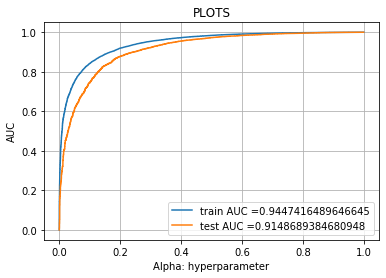

In [68]:
naive_bayes = MultinomialNB(alpha=best_alpha,fit_prior=True,class_prior=[0.5,0.5])
naive_bayes.fit(X_train_final_tfidf,Y_Train)
pred_test_data=naive_bayes.predict(X_test_final_tfidf)
y_train_predicted_prob = naive_bayes.predict_proba(X_train_final_tfidf)[:,1]
y_test_predicted_prob=naive_bayes.predict_proba(X_test_final_tfidf)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("PLOTS")
plt.grid()
plt.show()

In [69]:
imp_neg_features ,imp_pos_features = findMax_features(naive_bayes)
print("---------------------------------------------------------")
print(imp_pos_features) 
print("---------------------------------------------------------")
print(imp_neg_features)

---------------------------------------------------------
[2633 5928 3505 2571 5913 3422 2274 4610 6346 1175]
---------------------------------------------------------
[5913 4610 3422 6660 2274 4112  802 6167 4136 5928]


In [70]:
feature_names = count_vector.get_feature_names()
coefs_with_fns = sorted(zip(naive_bayes.coef_[0], feature_names))
top_features = zip(coefs_with_fns[:20], coefs_with_fns[:-(20 + 1):-1])
list(top_features)

[((-13.448949204147413, 'championship'), (-4.9709825424369125, 'bleed')),
 ((-13.105332116649201, 'baba'), (-4.9792352003325115, 'cranappl')),
 ((-13.0702201859657, 'cliam'), (-5.020497277991727, 'butterscotchey')),
 ((-13.04744161530687, 'agon'), (-5.052276168645954, 'biz')),
 ((-12.960547516854746, 'breakdown'), (-5.060839014022004, 'crafti')),
 ((-12.949944935541746, 'dehidr'), (-5.078882900703493, 'bup')),
 ((-12.839725793241614, 'bartlet'), (-5.153263587474656, 'benifitt')),
 ((-12.726170451865762, 'charit'), (-5.18308658111584, 'chiriqui')),
 ((-12.70497584356906, 'alexia'), (-5.26415183735628, 'daintili')),
 ((-12.650991017140644, 'chazuk'), (-5.295478509528785, 'applestrawberri')),
 ((-12.633726875429488, 'bettter'), (-5.355898714523881, 'cayenn')),
 ((-12.626425541147698, 'anfair'), (-5.399879919662171, 'cuaght')),
 ((-12.615713546229573, 'bred'), (-5.461795791946679, 'cachou')),
 ((-12.5810022201916, 'campagin'), (-5.5061653301724, 'alabama')),
 ((-12.571953005290663, 'affici

In [71]:
roc_auc_score(Y_Test,y_test_predicted_prob)
print(classification_report(Y_Test,pred_test_data))
print(confusion_matrix(Y_Test,pred_test_data))

              precision    recall  f1-score   support

    negative       0.47      0.81      0.59      2457
    positive       0.97      0.87      0.92     17543

    accuracy                           0.86     20000
   macro avg       0.72      0.84      0.75     20000
weighted avg       0.91      0.86      0.88     20000

[[ 1994   463]
 [ 2290 15253]]


In [72]:
pip install -U PTable

  Created wheel for PTable: filename=PTable-0.9.2-cp36-none-any.whl size=22908 sha256=656dec94e22e803669d9d533ad8022af6e62a478bf4a7561a07fdfc3138f55cc
  Stored in directory: /root/.cache/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
Successfully built PTable


In [73]:
from prettytable import PrettyTable

x= PrettyTable()

x.field_names = ["Vectorizer" , "Hyperparameter", "AUC"]
x.add_row(["Bag Of Words",0.1,0.8961787662046203])
x.add_row(["Tf-Idf",0.1,0.916085528070379])
x.add_row(["Bag Of Words with Feature Engineering ",0.1,0.8952631325046989])
x.add_row(["Tf-Idf with Feature Engineering",0.1,0.9154229153286575])
print(x)

+----------------------------------------+----------------+--------------------+
|               Vectorizer               | Hyperparameter |        AUC         |
+----------------------------------------+----------------+--------------------+
|              Bag Of Words              |      0.1       | 0.8961787662046203 |
|                 Tf-Idf                 |      0.1       | 0.916085528070379  |
| Bag Of Words with Feature Engineering  |      0.1       | 0.8952631325046989 |
|    Tf-Idf with Feature Engineering     |      0.1       | 0.9154229153286575 |
+----------------------------------------+----------------+--------------------+


#CONCLUSION : EVEN AFTER DOING FEATURIZATION TECHNIQUE BY ADDING NEW COLUMN CALLED TOTAL_WORDS , there is no increase in Accuracy Score.

# BEST ALPHA = 0.1 AND BEST AUC = 0.9160 USING TF-IDF FEATURIZATION TECHNIQUE